## "Elbow Detector" Method
High-pass filter the two signals to:
- Remove any DC offset between the signals
- Isolate **slope changes** (or "elbows") in the two signals and compare those directly, as constant-slope comparisons may make the horizontal vs. vertical offsets estimation ambiguous in real-time.

For our "elbow filter" we can try a second derivative estimator that simultaneously filters out noise. We'll create this filter by applying the "dirty derivative" filter to itself. The formula for the dirty derivative is

$$\dot{x}_{k}=\left(\frac{2\sigma-\Delta t}{2\sigma+\Delta t}\right)\dot{x}_{k-1}+\left(\frac{2}{2\sigma+\Delta t}\right)(x_{k}-x_{k-1})$$

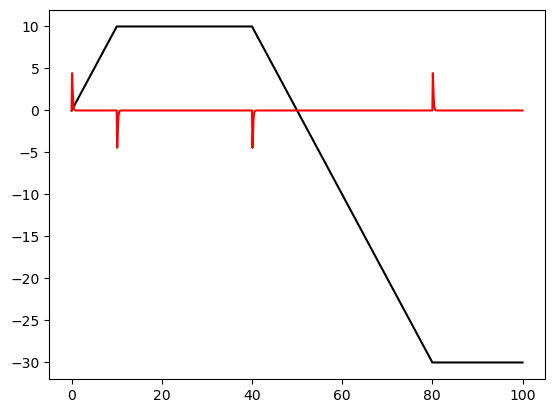

In [48]:
import numpy as np
import matplotlib.pyplot as plt

class ElbowFilter:
    def __init__(self, sigma1, dt, sigma2=None):
        self.sigma1 = sigma1
        self.sigma2 = sigma2 if sigma2 is not None else sigma1
        self.dt = dt
        self.x_km1 = 0
        self.xd_km1 = 0
        self.xdd_km1 = 0

    def reset(self):
        self.x_km1 = 0
        self.xd_km1 = 0
        self.xdd_km1 = 0

    def iterate(self, x_k):
        A1 = (2.0*self.sigma1-dt)/(2.0*self.sigma1+dt)
        B1 = 2.0/(2.0*self.sigma1+dt)
        A2 = (2.0*self.sigma2-dt)/(2.0*self.sigma2+dt)
        B2 = 2.0/(2.0*self.sigma2+dt)
        xd_k = A1 * self.xd_km1 + B1 * (x_k - self.x_km1)
        xdd_k = A2 * self.xdd_km1 + B2 * (xd_k - self.xd_km1)
        self.x_km1 = x_k
        self.xd_km1 = xd_k
        self.xdd_km1 = xdd_k
        return xdd_k

def plot_from_generator_fn(generator_fn, sigma1, sigma2=None):
    dt = 0.1
    
    t_sample1 = np.array([0.])
    x_sample1 = np.array([0.])
    for i in range(1000):
        t_sample1 = np.append(t_sample1, [t_sample1[i] + dt])
        x_sample1 = np.append(x_sample1, [generator_fn(i, dt, x_sample1[i])])
    
    ef = ElbowFilter(sigma1=sigma1, dt=dt, sigma2=sigma2)
    
    y_sample1 = np.zeros_like(x_sample1)
    for i in range(1001):
        y_sample1[i] = ef.iterate(x_sample1[i])
    
    plt.plot(t_sample1, x_sample1, "k-")
    plt.plot(t_sample1, y_sample1, "r-")
    plt.show()

def generator1(i, dt, xm1):
    if 0 <= i < 100:
        return xm1 + dt
    elif 100 <= i < 400:
        return xm1
    elif 400 <= i < 800:
        return xm1 - dt
    elif 800 <= i < 1000:
        return xm1

plot_from_generator_fn(generator1, 0.1)

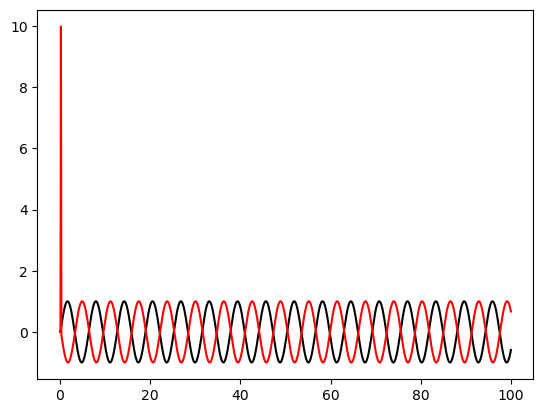

In [49]:
def generator2(i, dt, xm1):
    return np.sin(i*dt)

plot_from_generator_fn(generator2, 0.05)

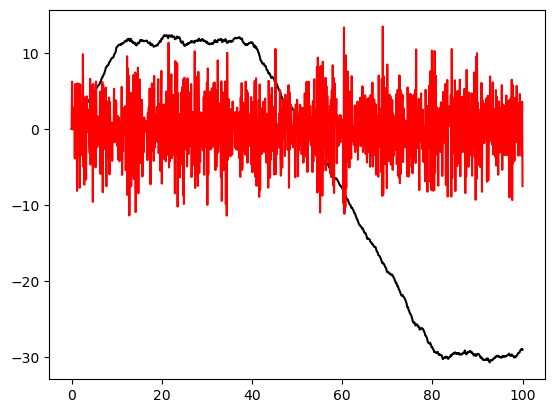

In [56]:
def generator3(i, dt, xm1):
    if 0 <= i < 100:
        return xm1 + dt + np.random.normal(0, 0.1)
    elif 100 <= i < 400:
        return xm1 + np.random.normal(0, 0.1)
    elif 400 <= i < 800:
        return xm1 - dt + np.random.normal(0, 0.1)
    elif 800 <= i < 1000:
        return xm1 + np.random.normal(0, 0.1)

plot_from_generator_fn(generator3, 0.01, .5)

Not super effective on noisy signals. How about just applying one dirty derivative and then doing heuristic-based edge detection on that signal?

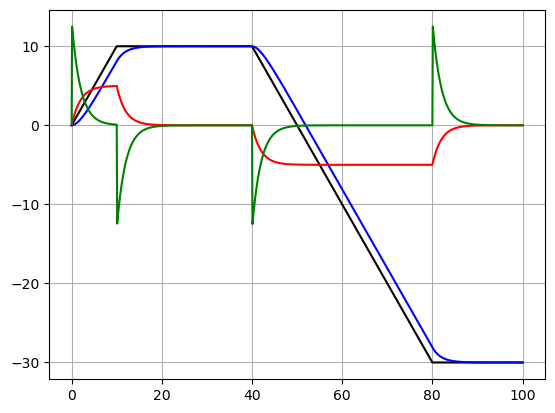

In [103]:
class ElbowFilter2:
    def __init__(self, sigma, dt):
        self.sigma = sigma
        self.dt = dt
        self.x_km1 = 0
        self.xd_km1 = 0

    def reset(self):
        self.x_km1 = 0
        self.xd_km1 = 0

    def iterate(self, u_k):
        sigma = 1.0
        A = (2.0*sigma-dt)/(2.0*sigma+dt)
        B = 2.0/(2.0*sigma+dt)
        x_k = (1.0 - self.sigma) * self.x_km1 + self.sigma * u_k
        # xd_k = A * self.xd_km1 + B * (x_k - self.x_km1)
        xd_k = 5.0 * (x_k - self.x_km1) / dt
        xdd_k = 5.0 * (xd_k - self.xd_km1) / dt
        self.x_km1 = x_k
        self.xd_km1 = xd_k
        return x_k, xd_k, xdd_k

def plot2_from_generator_fn(generator_fn, sigma):
    dt = 0.1
    
    t_sample1 = np.array([0.])
    x_sample1 = np.array([0.])
    for i in range(1000):
        t_sample1 = np.append(t_sample1, [t_sample1[i] + dt])
        x_sample1 = np.append(x_sample1, [generator_fn(i, dt, x_sample1[i])])
    
    ef = ElbowFilter2(sigma=sigma, dt=dt)
    
    y_sample1 = np.zeros_like(x_sample1)
    z_sample1 = np.zeros_like(x_sample1)
    a_sample1 = np.zeros_like(x_sample1)
    for i in range(1001):
        y_sample1[i], z_sample1[i], a_sample1[i] = ef.iterate(x_sample1[i])
    
    plt.plot(t_sample1, x_sample1, "k-")
    plt.plot(t_sample1, y_sample1, "b-")
    plt.plot(t_sample1, z_sample1, "r-")
    plt.plot(t_sample1, a_sample1, "g-")
    plt.grid()
    plt.show()

plot2_from_generator_fn(generator1, 0.05)

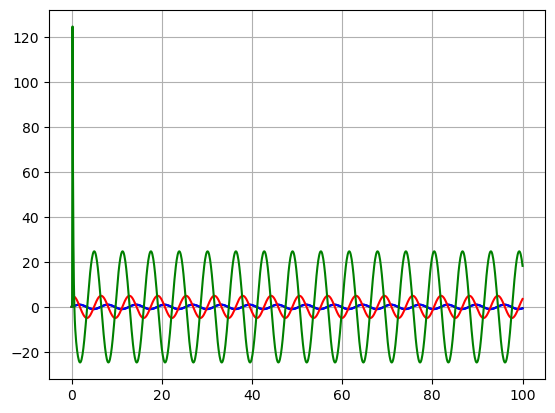

In [104]:
plot2_from_generator_fn(generator2, 0.5)

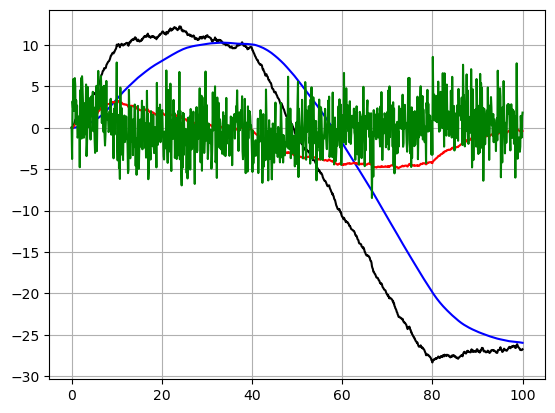

In [105]:
plot2_from_generator_fn(generator3, 0.01)

In [12]:
## Derive the second derivative estimator

# Dirty derivative (we will use exponents to represent time steps since they compose identically)
var("xdot")
var("x")
var("s")
var("dt")
var("k")
dirtyDerivative = (xdot^k == (2*s-dt)/(2*s+dt)*xdot^(k-1)+2/(2*s+dt)*(x^k-x^(k-1)))

# Apply the dirty derivative again
var("xddot")
dirtyDDerivative = (xddot^k == (2*s-dt)/(2*s+dt)*xddot^(k-1)+2/(2*s+dt)*(xdot^k-xdot^(k-1)))
dirtyDDerivative.subs(dirtyDerivative)

xddot^k == -(dt - 2*s)*xddot^(k - 1)/(dt + 2*s) - 2*(xdot^(k - 1) + (dt - 2*s)*xdot^(k - 1)/(dt + 2*s) + 2*(x^(k - 1) - x^k)/(dt + 2*s))/(dt + 2*s)

So the formula for the second derivative "elbow" filter is

$$\ddot{x}_k=\frac{2\sigma-\Delta t}{2\sigma + \Delta t}\ddot{x}_{k-1}-2\left(\dot{x}_{k-1}+\frac{\Delta t - 2\sigma}{\Delta t+2\sigma}\dot{x}_{k-1}+2\right)$$

## Kalman Filter Method
References:
- https://beteje.github.io/assets/pdf/2019_APSIPA.pdf
- https://www.sciencedirect.com/science/article/pii/S1474667016396033